# Sentiment Analysis for Stock Market Prediction #
Team Members: Anjan Shrestha, Aashish Pandey, Umesh Jaiswal, Puja Dhungana

Group Number: 1

### Imports and Packages ###

In [ ]:
# For flair model
import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

# For text cleaning and preparation
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

# For dealing with dataframe
import pandas as pd

# For dealing with np array
import numpy as np

# For making request to API
import requests

# For calling yahoo finance to get stock price 
import pandas_datareader as pdr
import datetime as dt
from datetime import timedelta
import dateutil.parser as dparser

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
alt.renderers.enable('default')
import seaborn as sns

# For dealing with system files and folders
import os
import json

# For model
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from transformers import pipeline

# For math operation
import math

# Install Flair module
!pip install flair

### Model Properties ###

In [2]:
# Twitter Properties
TWITTER_FILE_NAME = 'twitter_'
TWITTER_SEARCH_URI = 'https://api.twitter.com/1.1/search/tweets.json'  # Twitter API search URI
TWITTER_BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAAF8pUQEAAAAAL7QXs9hTVl4Zq2GE%2FYhVQeJ9kyE%3DUaV8oJRddqkRSZfDXYqI7qS2lBnfRV8lj2S0K6BPJeg4pPfRQf'   # Token for twitter API
TWITTER_MAX_SENTIMENT = 200   # Maximum number of sentiments to fetch from twitter API

# Dataframe Properties
AUTHOR_NAME = 'Author_Name'
FOLLOWERS_COUNT = 'Followers_Count'
FRIENDS_COUNT = 'Friends_Count'
TEXT = 'Text'
RETWEET_COUNT = 'Retweet_Count'
CREATED_AT = 'Created_At'
SENTIMENT = 'Sentiment'
SENTIMENT_PROBABILITY = 'Sentiment_Probability'
STOCK_PRICE = 'Stock_Price'

# Stock Properties 
STOCK_NAME = 'tesla'    # Stock name to run model
STOCK_TICKER = 'TSLA'

## 1. Extract Raw Data ##
Calling Twitter API to get raw sentiments from users and saving to json file

In [3]:
# Function to call Twitter API
def call_twitter_api(stock_name, max_sentiment, request_date):
    # Parmeters to pass to twitter API
    params = {
        'q': STOCK_NAME,
        'tweet_mode': 'extended',
        'lang': 'en',
        'count': max_sentiment,
        'until': request_date
    }

    # Call twitter API
    response = requests.get(
        TWITTER_SEARCH_URI,
        params=params,
        headers={
            'authorization': 'Bearer '+ TWITTER_BEARER_TOKEN
    })

    return response.json()

In [4]:
data_path = './data/'
response_jsons = []
today_date = dt.datetime.now()
files = [file for file in os.listdir(data_path) if os.path.isfile(data_path + file) and not file.startswith('.')]

for i in range(7):
    request_date = (today_date - timedelta(days=i) ).strftime("%Y-%m-%d")
    file_name = TWITTER_FILE_NAME + request_date
    
    if file_name not in files:  
        response_json = call_twitter_api(STOCK_NAME, TWITTER_MAX_SENTIMENT, request_date)
        
        # Output json to file
        # Note: File contains sentiment for the previous day
        with open((data_path + file_name + '.json'), 'w') as file:
            file.write(json.dumps(response_json))

## 2. Dataset Creation ##

### I. Converting twitter response json from file to dataset ###

In [5]:
# Reading json file 
response_jsons = []
files = [file for file in os.listdir(data_path) if os.path.isfile(data_path + file) and not file.startswith('.')]

for file in sorted(files):
    with open(data_path + file) as json_file:
        json_data = json.load(json_file)
        response_jsons.append(json_data)

In [6]:
# Defining dataframe with features 
df = pd.DataFrame(columns=[
    AUTHOR_NAME, 
    FOLLOWERS_COUNT, 
    FRIENDS_COUNT, 
    TEXT, 
    RETWEET_COUNT, 
    CREATED_AT
])

In [7]:
# Converting twitter response json to dataset selecting required features
for response_json in response_jsons:
    for status in response_json['statuses']:    
        df = df.append({
            AUTHOR_NAME: status['user']['name'],
            FOLLOWERS_COUNT: status['user']['followers_count'], 
            FRIENDS_COUNT: status['user']['friends_count'],
            TEXT: status['full_text'],
            RETWEET_COUNT: status['retweet_count'],
            CREATED_AT: status['created_at']
        }, ignore_index=True)

In [8]:
df.shape

(2872, 6)

In [9]:
df.head(5)

,Author_Name,Followers_Count,Friends_Count,Text,Retweet_Count,Created_At
0,Primero Amigo,35,146,RT @teslaunivrse: #cybertruck looks incredible...,222,Fri Oct 22 23:59:46 +0000 2021
1,Fitsum,76,415,"Tesla (TSLA) reaches new all-time high, surpas...",0,Fri Oct 22 23:59:46 +0000 2021
2,Chris Meyer,15,7,@MicroVision Hopefully #Microvision #MVIS will...,0,Fri Oct 22 23:59:40 +0000 2021
3,Lavdish,30,218,RT @jingkey_: jinki said a camera director who...,182,Fri Oct 22 23:59:40 +0000 2021
4,ʞooʞıɾ —,393,2760,RT @Jopromote: Hey Guys Amazing chance to win ...,960,Fri Oct 22 23:59:40 +0000 2021


### II. Creating Stock Price label by using yahoo finance module ###

In [10]:
# Function to format date to yyyy-MM-dd
def format_date(mydate):
    parsed_date = dparser.parse(mydate, fuzzy=True)
    date_time = dt.datetime(parsed_date.year, parsed_date.month, parsed_date.day)
    
    no_of_week = date_time.weekday()
    if no_of_week < 5:
        return str(parsed_date.year)+'-'+str(parsed_date.month)+'-'+str(parsed_date.day)
    elif no_of_week == 5:
        return str(parsed_date.year)+'-'+str(parsed_date.month)+'-'+str(parsed_date.day - 1)
    elif no_of_week == 6:
        return str(parsed_date.year)+'-'+str(parsed_date.month)+'-'+str(parsed_date.day - 2)

In [11]:
df[CREATED_AT] = pd.Series(map(format_date,df[CREATED_AT]))

In [12]:
# Get start and end date to fetch stock price 
start_date = df[CREATED_AT].min()
end_date = dt.date.today()

# Creating dictionary of date and stock price for particular stock 
stock_price = pdr.get_data_yahoo(STOCK_TICKER, start = start_date, end = end_date)['Close']

In [13]:
df[STOCK_PRICE] = pd.Series([ stock_price[mydate] for mydate in df[CREATED_AT]])

## 3. Feature Engineering ##

### I. Applying text cleaning methods ###

In [14]:
# Function to clean text by applying several text cleaning methods
def clean_prepare_text(text):
    # 1. Clean the text - cleaning special character
    filtered_text = text.replace("\r", " ").replace("\n", " ").replace("  ", " ")

    # 2. Remove all the punctuations
    for punct_sign in list("?:!,;\""):
        filtered_text = filtered_text.replace(punct_sign, '')

    # 3. Convert to lowercase 
    filtered_text = filtered_text.lower()

    # 4. Remove stopwords
    filtered_text = " ".join([text for text in filtered_text.split(" ") if text not in stopwords.words('english')])

    # 5. Remove meaningles words 
    filtered_text = filtered_text.replace("\'ve", '').replace("\'s", '').replace("\'m", '').replace("\'t", '')

    # 6.a. Stemming
    filtered_text = " ".join([stemmer.stem(text) for text in filtered_text.split(" ")])

    # 6.b. lemmatization
    filtered_text = " ".join([lemmatizer.lemmatize(text) for text in filtered_text.split(" ")])

    return filtered_text


In [15]:
# Clean and Prepare text for further processing
df[TEXT] = [clean_prepare_text(text) for text in df[TEXT]]

### II. Creating Sentiment Feature by using pretrained 'flair' Model ###

In [16]:
sentiments = []
sentiment_probabilities = []

for text in df[TEXT]:
    sentence = flair.data.Sentence(text)
    sentiment_model.predict(sentence)
    
    probability = sentence.labels[0].score  # numerical value 0-1
    sentiment = sentence.labels[0].value    # 'POSITIVE' or 'NEGATIVE'
    
    sentiments.append(sentiment)
    sentiment_probabilities.append(probability)
    
df[SENTIMENT] = sentiments
df[SENTIMENT_PROBABILITY] = sentiment_probabilities

In [17]:
# Displaying top 5 record for visualizing
df.head(5)

,Author_Name,Followers_Count,Friends_Count,Text,Retweet_Count,Created_At,Stock_Price,Sentiment,Sentiment_Probability
0,Primero Amigo,35,146,rt @teslaunivrs #cybertruck look incredible. 😍...,222,2021-10-22,909.679993,POSITIVE,0.990210
1,Fitsum,76,415,tesla (tsla) reach new all-tim high surpass $9...,0,2021-10-22,909.679993,POSITIVE,0.960430
2,Chris Meyer,15,7,@microvis hope #microvis #mvi start lidar prod...,0,2021-10-22,909.679993,POSITIVE,0.928949
3,Lavdish,30,218,rt @jingkey_ jinki said camera director work i...,182,2021-10-22,909.679993,POSITIVE,0.837071
4,ʞooʞıɾ —,393,2760,rt @jopromot hey guy amaz chanc win 🤩👇 $67000 ...,960,2021-10-22,909.679993,POSITIVE,0.992259


### III. Encoding the categorical variable ###

In [18]:
def is_pos(sentiment):
    if sentiment=='POSITIVE':
        return 1
    else:
        return -1
df[SENTIMENT] = pd.Series([is_pos(sentiment) for sentiment in df[SENTIMENT]])

In [19]:
# Displaying top 5 record for visualizing after encoding
df.head(5)

,Author_Name,Followers_Count,Friends_Count,Text,Retweet_Count,Created_At,Stock_Price,Sentiment,Sentiment_Probability
0,Primero Amigo,35,146,rt @teslaunivrs #cybertruck look incredible. 😍...,222,2021-10-22,909.679993,1,0.990210
1,Fitsum,76,415,tesla (tsla) reach new all-tim high surpass $9...,0,2021-10-22,909.679993,1,0.960430
2,Chris Meyer,15,7,@microvis hope #microvis #mvi start lidar prod...,0,2021-10-22,909.679993,1,0.928949
3,Lavdish,30,218,rt @jingkey_ jinki said camera director work i...,182,2021-10-22,909.679993,1,0.837071
4,ʞooʞıɾ —,393,2760,rt @jopromot hey guy amaz chanc win 🤩👇 $67000 ...,960,2021-10-22,909.679993,1,0.992259


### IV. Exploratory Data Analysis ###

In [20]:
df.describe(include = 'all')

,Author_Name,Followers_Count,Friends_Count,Text,Retweet_Count,Created_At,Stock_Price,Sentiment,Sentiment_Probability
count,2872,2872.0,2872.0,2872,2872.0,2872,2872.000000,2872.000000,2872.000000
unique,2645,1165.0,1465.0,2052,457.0,20,NaN,NaN,NaN
top,Kirill Klip 🌎 ⚡️⛏ #Gold & #rEVolution 🔌🔋🚘,1.0,0.0,rt @elonmusk @drelidavid wfp describ twitter t...,0.0,2021-10-22,NaN,NaN,NaN
freq,8,39.0,17.0,51,999.0,300,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,1096.086228,-0.029248,0.892062
std,NaN,NaN,NaN,NaN,NaN,NaN,93.748428,0.999746,0.140845
min,NaN,NaN,NaN,NaN,NaN,NaN,909.679993,-1.000000,0.501194
25%,NaN,NaN,NaN,NaN,NaN,NaN,1033.420044,-1.000000,0.835089
50%,NaN,NaN,NaN,NaN,NaN,NaN,1114.000000,-1.000000,0.962207
75%,NaN,NaN,NaN,NaN,NaN,NaN,1162.939941,1.000000,0.994706


/Users/aj/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


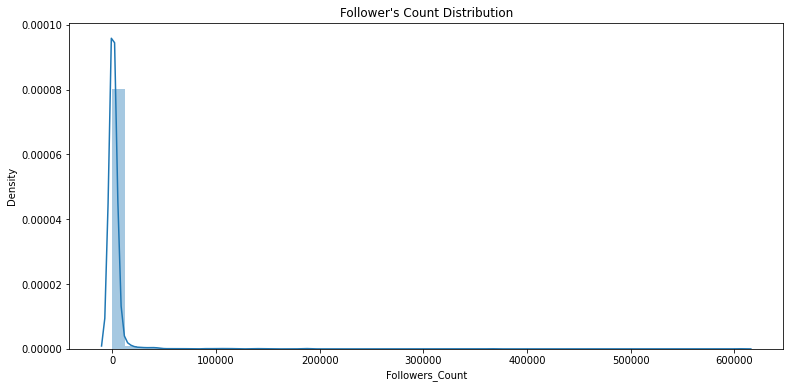

In [21]:
plt.figure(figsize=(12.8,6))
sns.distplot(df[FOLLOWERS_COUNT]).set_title('Follower\'s Count Distribution');

In [22]:
bars = alt.Chart(df).mark_bar(size=50).encode(
    x=alt.X(SENTIMENT),
    y=alt.Y("count():Q", axis=alt.Axis(title='Number of tweets')),
    tooltip=[alt.Tooltip('count()', title='Number of tweets'), SENTIMENT],
    color=SENTIMENT

)

text = bars.mark_text(
    align='center',
    baseline='bottom',
).encode(
    text='count()'
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "Number of tweets in each sentiment",
)


alt.LayerChart(...)

## 4. Split data into train and test ##

In [23]:
train_index = 0.7 * df.shape[0]
X_train = df[:int(train_index)][[FOLLOWERS_COUNT, FRIENDS_COUNT, RETWEET_COUNT, SENTIMENT, SENTIMENT_PROBABILITY]]
y_train =  df[:int(train_index)][STOCK_PRICE]

X_test = df[int(train_index):][[FOLLOWERS_COUNT, FRIENDS_COUNT, RETWEET_COUNT, SENTIMENT, SENTIMENT_PROBABILITY]]
y_test =  df[int(train_index):][STOCK_PRICE]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2010, 5)
(2010,)
(862, 5)
(862,)


## 5. Create, Train and Evaluate Model ##

### I. LSTM Model ###

In [24]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train_lstm =np.asarray(X_train).astype(np.float32).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = np.asarray(X_test).astype(np.float32).reshape(X_test.shape[0], X_test.shape[1], 1)

# Create Model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(5,1)))
model_lstm.add(LSTM(50, return_sequences=True))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

# Train Model
model_lstm.fit(X_train_lstm, y_train, validation_data=(X_test_lstm, y_test), epochs=25, batch_size=10, verbose=0)

# Make prediction for testing dataset
y_pred = model_lstm.predict(X_test_lstm).reshape(-1,1)

# Calculate RMSE score
rmse_lstm = math.sqrt(mean_squared_error(y_pred, y_test))

2021-11-23 22:14:12.257404: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


2021-11-23 22:14:13.029010: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### II. Linear Regression ###

In [25]:
# Create Model
model_lr = LinearRegression()

# Train Model
model_lr.fit(X_train,y_train)

# Make prediction for testing dataset
y_pred = model_lr.predict(X_test)

# Calculate RMSE score
rmse_lr = math.sqrt(mean_squared_error(y_pred, y_test))

### III. Decision Tree Regression ###

In [26]:
# Create Model
model_dt = DecisionTreeRegressor()

# Train Model
model_dt.fit(X_train,y_train)

# Make prediction for testing dataset
y_pred = model_dt.predict(X_test)

# Calculate RMSE score
rmse_dt = math.sqrt(mean_squared_error(y_pred, y_test))

### IV. KNN Regression ###

In [27]:
# Create Model
model_knn = KNeighborsRegressor()

# Train Model
model_knn.fit(X_train,y_train)

# Make prediction for testing dataset
y_pred = model_knn.predict(X_test)

# Calculate RMSE score
rmse_knn = math.sqrt(mean_squared_error(y_pred, y_test))

## 6. Comparing and Choosing Best Model ##

In [28]:
# Using pandas dataframe to show data in a nice output table
rmse_df = pd.DataFrame(
            {'Model':                               ['LSTM',                         'Linear Regression',           'Decision Tree Regression',        'KNN Regression'],
             'RMSE':                                [rmse_lstm,                       rmse_lr,                       rmse_dt,                           rmse_knn]
            })
rmse_df

,Model,RMSE
0,LSTM,838.239920
1,Linear Regression,49.487728
2,Decision Tree Regression,129.527437
3,KNN Regression,68.506264


**Observation:**
Looking at the above RMSE score, the best model is found to be **Linear Regression**

## 7. Predict Next Stock Closing Price Using Best Model (Linear Regression) ##

In [29]:
# Calling Twitter API to fetch latest sentiment
request_date = (today_date - timedelta(days=i-1) ).strftime("%Y-%m-%d")
response_json = call_twitter_api(STOCK_NAME,1 , request_date)
          
# Creating input to predict future stock closing price 
for status in response_json['statuses']:   
    current_followers_count = status['user']['followers_count']
    current_friends_count = status['user']['friends_count']
    current_retweet_count = status['retweet_count']
    current_sentiment_text = status['full_text']
        
# Preparing text to pass it to flair model to get sentiment
current_cleaned_sentiment_text = clean_prepare_text(current_sentiment_text)

# Calling flair model to get current sentiment
sentence = flair.data.Sentence(current_cleaned_sentiment_text)
sentiment_model.predict(sentence)
current_sentiment_probability = sentence.labels[0].score 
current_sentiment = sentence.labels[0].value
        
# Encoding Sentiment
current_sentiment = is_pos(current_sentiment)

# Creating dataframe to pass as a input to the model
current_df = pd.DataFrame(columns=[
    FOLLOWERS_COUNT, 
    FRIENDS_COUNT, 
    RETWEET_COUNT, 
    SENTIMENT, 
    SENTIMENT_PROBABILITY
])
current_df = current_df.append({
            FOLLOWERS_COUNT: current_followers_count, 
            FRIENDS_COUNT: current_friends_count,
            RETWEET_COUNT: current_retweet_count,
            SENTIMENT: current_sentiment,
            SENTIMENT_PROBABILITY: current_sentiment_probability
        }, ignore_index=True)

# Making prediciton for next stock closing price using curren inputs
next_closing_price = model_lr.predict(current_df)[0]

In [30]:
# Current Date of Model Run
print('Current Date:                 ', dt.date.today())
print('Last Stock Closing Price:     ', y_test.iloc[-1])

# Next day price using Linear Regression
print('Next Stock Closing Price:     ', next_closing_price)

Current Date:                  2021-11-23
Last Stock Closing Price:      1156.8699951171875
Next Stock Closing Price:      1099.3018928804145


## 8. Apply Abstractive Summarization ##

In [31]:
# Calling Twitter API to fetch latest sentiments
today_date = dt.datetime.now()
request_date = (today_date - timedelta(days=-1) ).strftime("%Y-%m-%d")
response_json = call_twitter_api(STOCK_NAME, 15, request_date)

current_sentiment_text = ''
# Combining multiple sentiments to do abstractive summarization
for status in response_json['statuses']:
    current_sentiment_text += status['full_text']

In [32]:
# Current Sentiment Text
current_sentiment_text

"@teslaownersSV @elonmusk Yeah but I heard they’re going to do the Tesla bot in Palo Alto and it will clean our things and make croissants and coffee ☕️ in the morning 🙏🏻RT @TravisAllen02: Massie has an engineering degree from MIT, has solar panels on his house, drives a Tesla, and has convinced rural Kentuc…RT @invest_answers: IA #TATuesdays - the best all-around indicators all wrapped up in a simple easy to learn video - #Bitcoin market has a…No new Form 4's from Tesla yesterday or today yet. That's good news for the split rumor!\n$TSLA #120921 #TESLART @TravisAllen02: Massie has an engineering degree from MIT, has solar panels on his house, drives a Tesla, and has convinced rural Kentuc…RT @silverph: @elonmusk “Dad, the Tesla’s talking!” 😂 Tobie is in the spotlight! I wish I can open and close the frunk automatically to giv…RT @TravisAllen02: Massie has an engineering degree from MIT, has solar panels on his house, drives a Tesla, and has convinced rural Kentuc…@sirbu_ion1 @crypto_b

In [ ]:
# Declaring summarization model
summarizer = pipeline("summarization")

# Predicting the abstractive summarization using the model
summary_text = summarizer(current_sentiment_text, max_length=100, min_length=5)[0]['summary_text']

In [41]:
# Displaying Summarized Text
print(summary_text)

 No new Form 4's from Tesla yesterday or today yet yet . That's good news for the split rumor! @teslaownersSV @elonmusk Yeah but I heard they’re going to do the Tesla bot in Palo Alto and it will clean our things and make croissants and coffee in the morning .
